In [1050]:
import numpy as np
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from requests import get
import unicodedata
from bs4 import BeautifulSoup
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score
import sys
%matplotlib inline

# Reading the data

In [1051]:
df = pd.read_excel('Cleaned2_with genre.xlsx')

In [1052]:
df.shape

(4101, 18)

In [1053]:
df.describe()

,title_year,duration,actor1_insta,actor2_insta,cast_total_insta_followers,facenumber_in_poster,budget,IMDB_Score,Gross
count,4066.000000,4095.000000,1.183000e+03,2.130000e+02,4.101000e+03,4091.000000,3.825000e+03,4094.000000,3.612000e+03
mean,2002.504181,109.187302,1.325779e+07,1.001662e+07,4.039163e+06,1.424835,3.840296e+07,6.392013,5.400469e+07
std,11.643035,22.976195,4.141268e+07,3.891333e+07,2.505179e+07,2.069669,4.504852e+07,1.097509,7.077348e+07
min,1930.000000,7.000000,0.000000e+00,2.100000e+01,0.000000e+00,0.000000,1.300000e+04,1.600000,1.620000e+02
25%,1999.000000,95.000000,1.529975e+05,9.443900e+04,0.000000e+00,0.000000,1.000000e+07,5.800000,1.013882e+07
50%,2005.000000,105.000000,1.238200e+06,7.482130e+05,0.000000e+00,1.000000,2.400000e+07,6.500000,3.151033e+07
75%,2010.000000,119.000000,9.481862e+06,4.044512e+06,0.000000e+00,2.000000,5.000000e+07,7.200000,6.891792e+07
max,2016.000000,334.000000,3.714007e+08,3.713459e+08,3.884086e+08,43.000000,7.000000e+08,9.500000,7.605058e+08


In [1054]:
df.head()

,movie_title,title_year,duration,director_name,genre1,genre2,actor_1_name,actor1_insta,actor_2_name,actor2_insta,cast_total_insta_followers,facenumber_in_poster,plot_keywords,country,content_rating,budget,IMDB_Score,Gross
0,Avatar,2009.0,178.0,James Cameron,Action,Adventure,CCH Pounder,NaN,Joel David Moore,NaN,0,0.0,avatar|future|marine|native|paraplegic,USA,PG-13,237000000.0,7.9,760505847.0
1,Pirates of the Caribbean: At World's End,2007.0,169.0,Gore Verbinski,Adventure,Fantasy,Johnny Depp,28225408.0,Orlando Bloom,6714134.0,34939542,0.0,goddess|marriage ceremony|marriage proposal|pi...,USA,PG-13,300000000.0,7.1,309404152.0
2,Spectre,2015.0,148.0,Sam Mendes,Action,Adventure,Christoph Waltz,154783.0,Rory Kinnear,NaN,154783,1.0,bomb|espionage|sequel|spy|terrorist,UK,PG-13,245000000.0,6.8,200074175.0
3,The Dark Knight Rises,2012.0,164.0,Christopher Nolan,Action,Crime,Tom Hardy,9392965.0,Christian Bale,NaN,9392965,0.0,deception|imprisonment|lawlessness|police offi...,USA,PG-13,250000000.0,8.5,448130642.0
4,John Carter,2012.0,132.0,Andrew Stanton,Action,Adventure,Daryl Sabara,NaN,Samantha Morton,NaN,0,1.0,alien|american civil war|male nipple|mars|prin...,USA,PG-13,263700000.0,6.6,73058679.0


In [1055]:
col = list(df.columns)
col

['movie_title',
 'title_year',
 'duration',
 'director_name',
 'genre1',
 'genre2',
 'actor_1_name',
 'actor1_insta',
 'actor_2_name',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'plot_keywords',
 'country',
 'content_rating',
 'budget',
 'IMDB_Score',
 'Gross']

# Pre-Processing

In [1056]:
df['title_year'].fillna(value=df['title_year'].median(), inplace=True)
df['duration'].fillna(value=df['duration'].median(), inplace=True)
df = df[df['IMDB_Score'].notnull()]
df = df[df['Gross'].notnull()]
df['budget'].fillna(value=df['budget'].median(), inplace=True)
df['facenumber_in_poster'].fillna(value=df['facenumber_in_poster'].median(), inplace=True)
df['actor1_insta'].fillna(value=df['actor1_insta'].median(), inplace=True)
df['actor2_insta'].fillna(value=df['actor2_insta'].median(), inplace=True)

In [1057]:
df.isnull().sum()

movie_title                     0
title_year                      0
duration                        0
director_name                   1
genre1                        127
genre2                        597
actor_1_name                    0
actor1_insta                    0
actor_2_name                    1
actor2_insta                    0
cast_total_insta_followers      0
facenumber_in_poster            0
plot_keywords                  20
country                         0
content_rating                 22
budget                          0
IMDB_Score                      0
Gross                           0
dtype: int64

In [1058]:
actor1nameset =  list(df["actor_1_name"])
actor2nameset =  list(df["actor_2_name"])
actor1instaset=  list(df["actor1_insta"])
actor2instaset=  list(df["actor2_insta"])
ac1insta={actor1nameset[i]: actor1instaset[i] for i in range(len(actor1nameset))}
ac2insta={actor2nameset[i]: actor2instaset[i] for i in range(len(actor2nameset))}

In [1059]:
# col = list(df.describe().columns)
# sc1 = StandardScaler()
# temp = sc1.fit_transform(df[col])
# df[col] = temp
# mean1 = sc1.mean_
# std1 = sc1.scale_
# df.head()

In [1060]:
col = list(df.describe().columns)
sc1 = MinMaxScaler()
temp = sc1.fit_transform(df[col])
df[col] = temp
min_value1 = sc1.data_min_
max_value1 = sc1.data_max_
df.head()

,movie_title,title_year,duration,director_name,genre1,genre2,actor_1_name,actor1_insta,actor_2_name,actor2_insta,cast_total_insta_followers,facenumber_in_poster,plot_keywords,country,content_rating,budget,IMDB_Score,Gross
0,Avatar,0.9125,0.480000,James Cameron,Action,Adventure,CCH Pounder,0.004212,Joel David Moore,0.00203,0.000000,0.000000,avatar|future|marine|native|paraplegic,USA,PG-13,0.338558,0.818182,1.000000
1,Pirates of the Caribbean: At World's End,0.8875,0.450000,Gore Verbinski,Adventure,Fantasy,Johnny Depp,0.075997,Orlando Bloom,0.01808,0.089956,0.000000,goddess|marriage ceremony|marriage proposal|pi...,USA,PG-13,0.428560,0.714286,0.406840
2,Spectre,0.9875,0.380000,Sam Mendes,Action,Adventure,Christoph Waltz,0.000417,Rory Kinnear,0.00203,0.000399,0.023256,bomb|espionage|sequel|spy|terrorist,UK,PG-13,0.349987,0.675325,0.263080
3,The Dark Knight Rises,0.9500,0.433333,Christopher Nolan,Action,Crime,Tom Hardy,0.025291,Christian Bale,0.00203,0.024183,0.000000,deception|imprisonment|lawlessness|police offi...,USA,PG-13,0.357130,0.896104,0.589253
4,John Carter,0.9500,0.326667,Andrew Stanton,Action,Adventure,Daryl Sabara,0.004212,Samantha Morton,0.00203,0.000000,0.023256,alien|american civil war|male nipple|mars|prin...,USA,PG-13,0.376702,0.649351,0.096066


In [1061]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categories = df['actor_1_name']
encoded_categories = le.fit_transform(categories)
df['Actor_1_class']=encoded_categories

In [1062]:
le = LabelEncoder()
categories = df['director_name']
encoded_categories = le.fit_transform(categories)
df['director_class']=encoded_categories
df['director_class']

0        591
1        518
2       1330
3        242
4         62
        ... 
4085     176
4086     610
4088    1260
4097     240
4100    1570
Name: director_class, Length: 3612, dtype: int32

In [1063]:
le = LabelEncoder()
categories = df['actor_2_name']
encoded_categories = le.fit_transform(categories)
df['Actor_2_class']=encoded_categories

In [1064]:
le = LabelEncoder()
categories = df['genre1']
encoded_categories = le.fit_transform(categories)
df['Genre1']=encoded_categories
print(max(encoded_categories))

19


In [1065]:
le = LabelEncoder()
categories = df['genre2']
encoded_categories = le.fit_transform(categories)
df['Genre2']=encoded_categories
print(max(encoded_categories))

18


In [1066]:
le = LabelEncoder()
categories = df['country']
encoded_categories = le.fit_transform(categories)
df['Country']=encoded_categories
print(max(encoded_categories))

33


In [1067]:
le = LabelEncoder()
categories = df['content_rating']
encoded_categories = le.fit_transform(categories)
df['Content_rating']=encoded_categories
print(max(encoded_categories))

12


In [1068]:
df=df.drop(['plot_keywords'], axis = 1)

In [1069]:
df = df.reindex(columns=['movie_title',
 'title_year',
 'duration',
 'director_name',
 'director_class',
 'genre1',
 'Genre1',   
 'genre2',
 'Genre2',
 'actor_1_name',
 'Actor_1_class',          
 'actor1_insta',
 'actor_2_name',
 'Actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'country','Country',
 'content_rating', 'Content_rating',
 'budget',
 'Gross',
 'IMDB_Score'])

In [1070]:
features = list(df.columns)
for col in ['IMDB_Score','Gross','actor_1_name','actor_2_name','director_name','movie_title','content_rating','country','genre1','genre2']:
        features.remove(col)

In [1071]:
df[features].head()

,title_year,duration,director_class,Genre1,Genre2,Actor_1_class,actor1_insta,Actor_2_class,actor2_insta,cast_total_insta_followers,facenumber_in_poster,Country,Content_rating,budget
0,0.9125,0.480000,591,0,1,166,0.004212,940,0.00203,0.000000,0.000000,33,7,0.338558
1,0.8875,0.450000,518,1,8,626,0.075997,1500,0.01808,0.089956,0.000000,33,7,0.428560
2,0.9875,0.380000,1330,0,1,223,0.000417,1689,0.00203,0.000399,0.023256,32,7,0.349987
3,0.9500,0.433333,242,0,4,1217,0.025291,355,0.00203,0.024183,0.000000,33,7,0.357130
4,0.9500,0.326667,62,0,1,285,0.004212,1728,0.00203,0.000000,0.023256,33,7,0.376702


<AxesSubplot:>

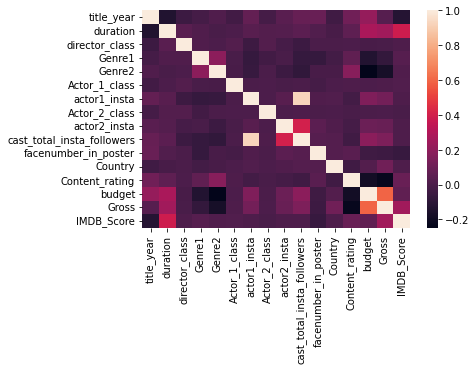

In [1072]:
sns.heatmap(df.corr())

In [1073]:
df.corr()

,title_year,duration,director_class,Genre1,Genre2,Actor_1_class,actor1_insta,Actor_2_class,actor2_insta,cast_total_insta_followers,facenumber_in_poster,Country,Content_rating,budget,Gross,IMDB_Score
title_year,1.000000,-0.136232,-0.048766,-0.023815,0.010500,-0.029072,0.070253,-0.023927,0.040987,0.080574,0.085311,-0.037880,0.112039,0.215224,0.031944,-0.126131
duration,-0.136232,1.000000,0.043456,0.014096,-0.008357,0.001992,0.034863,0.020601,0.029017,0.045039,0.015646,-0.009921,0.057946,0.278202,0.252674,0.384623
director_class,-0.048766,0.043456,1.000000,0.014379,0.000921,0.023465,-0.045048,0.020768,-0.017775,-0.049328,-0.003760,-0.002515,0.004464,-0.012517,-0.004741,0.009950
Genre1,-0.023815,0.014096,0.014379,1.000000,0.194735,-0.008303,-0.071126,-0.033663,-0.005230,-0.071478,-0.067997,-0.024785,0.061170,-0.132704,-0.080830,0.031605
Genre2,0.010500,-0.008357,0.000921,0.194735,1.000000,-0.012736,-0.067244,-0.000063,-0.049967,-0.086980,-0.010526,-0.011657,0.178732,-0.248343,-0.173656,0.013136
Actor_1_class,-0.029072,0.001992,0.023465,-0.008303,-0.012736,1.000000,-0.003283,0.005050,-0.005078,-0.003456,-0.022039,0.004805,0.009645,0.004074,0.009008,0.019012
actor1_insta,0.070253,0.034863,-0.045048,-0.071126,-0.067244,-0.003283,1.000000,0.003887,0.037946,0.924521,0.014490,0.017851,-0.027550,0.156375,0.120135,0.009367
Actor_2_class,-0.023927,0.020601,0.020768,-0.033663,-0.000063,0.005050,0.003887,1.000000,0.005051,0.005406,-0.001151,0.004221,-0.004603,-0.000294,0.004594,-0.008176
actor2_insta,0.040987,0.029017,-0.017775,-0.005230,-0.049967,-0.005078,0.037946,0.005051,1.000000,0.402183,0.046420,0.013933,-0.020455,0.093450,0.086804,0.005603
cast_total_insta_followers,0.080574,0.045039,-0.049328,-0.071478,-0.086980,-0.003456,0.924521,0.005406,0.402183,1.000000,0.029768,0.025844,-0.036845,0.188043,0.149202,0.009187


In [1074]:
actor1classset=  list(df["Actor_1_class"])
actor2classset=  list(df["Actor_2_class"])
directornameset=  list(df["director_name"])
directorclassset=  list(df["director_class"])
genre1set=list(df['genre1'])
Genre1set= list(df['Genre1'])
genre2set=list(df['genre2'])
Genre2set= list(df['Genre2'])
countryset=list(df['country'])
Countryset= list(df['Country'])
content_rating_set=list(df['content_rating'])
Content_rating_set= list(df['Content_rating'])
ac1={actor1nameset[i]: actor1classset[i] for i in range(len(actor1nameset))}
ac2={actor2nameset[i]: actor2classset[i] for i in range(len(actor2nameset))}
dc={directornameset[i]: directorclassset[i] for i in range(len(directornameset))}
g1={genre1set[i]: Genre1set[i] for i in range(len(genre1set))}
g2={genre2set[i]: Genre2set[i] for i in range(len(genre2set))}
cs={countryset[i]: Countryset[i] for i in range(len(countryset))}
cr={content_rating_set[i]: Content_rating_set[i] for i in range(len(content_rating_set))}

In [1075]:
df.head()

,movie_title,title_year,duration,director_name,director_class,genre1,Genre1,genre2,Genre2,actor_1_name,...,actor2_insta,cast_total_insta_followers,facenumber_in_poster,country,Country,content_rating,Content_rating,budget,Gross,IMDB_Score
0,Avatar,0.9125,0.480000,James Cameron,591,Action,0,Adventure,1,CCH Pounder,...,0.00203,0.000000,0.000000,USA,33,PG-13,7,0.338558,1.000000,0.818182
1,Pirates of the Caribbean: At World's End,0.8875,0.450000,Gore Verbinski,518,Adventure,1,Fantasy,8,Johnny Depp,...,0.01808,0.089956,0.000000,USA,33,PG-13,7,0.428560,0.406840,0.714286
2,Spectre,0.9875,0.380000,Sam Mendes,1330,Action,0,Adventure,1,Christoph Waltz,...,0.00203,0.000399,0.023256,UK,32,PG-13,7,0.349987,0.263080,0.675325
3,The Dark Knight Rises,0.9500,0.433333,Christopher Nolan,242,Action,0,Crime,4,Tom Hardy,...,0.00203,0.024183,0.000000,USA,33,PG-13,7,0.357130,0.589253,0.896104
4,John Carter,0.9500,0.326667,Andrew Stanton,62,Action,0,Adventure,1,Daryl Sabara,...,0.00203,0.000000,0.023256,USA,33,PG-13,7,0.376702,0.096066,0.649351


# Gross Prediction Model

In [1076]:
features

['title_year',
 'duration',
 'director_class',
 'Genre1',
 'Genre2',
 'Actor_1_class',
 'actor1_insta',
 'Actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'Country',
 'Content_rating',
 'budget']

In [1077]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df[features], df['Gross'], test_size=0.2)

In [1078]:
rf1 = xgb.XGBRegressor(n_estimators=250)

rf1.fit(X_train1, y_train1)

predictions1 = rf1.predict(X_test1)

In [1079]:
df.shape

(3612, 24)

In [1080]:
predictions1.shape

(723,)

In [1081]:
from sklearn.metrics import r2_score
score = r2_score(y_test1, predictions1)
print(score)

0.39424664536023823


In [1082]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test1, predictions1))
print(rmse)

0.06103378648578287


In [1083]:
predictions1 = predictions1 * (max_value1[8] - min_value1[8]) + min_value1[8]

In [1084]:
predictions1

array([ 1.33994880e+08,  5.57634000e+07,  1.81702912e+08,  1.11689950e+07,
        7.25886560e+07,  9.02372080e+07,  8.18971760e+07,  5.40270900e+06,
        7.14655950e+06,  2.07950980e+07,  1.25731550e+07,  3.66239040e+07,
        3.62465504e+08,  3.20364300e+07, -7.21347200e+06,  6.75488720e+07,
        4.79188960e+07,  1.17145080e+07, -4.10310840e+03,  6.59448240e+07,
       -5.61476250e+06,  2.49765984e+08,  7.15388240e+07,  1.23510080e+08,
        1.76426912e+08,  2.53004300e+07,  6.15709120e+07,  8.34761760e+07,
        4.22809840e+07,  3.06492180e+07,  1.55762890e+07,  5.53054800e+07,
        2.78107520e+08,  3.02340060e+07,  2.23878020e+07,  2.58983940e+07,
        1.60664120e+07,  1.26442670e+07,  9.07361760e+07,  9.06992240e+07,
        8.98897440e+07,  1.00151890e+07,  4.00737040e+07,  4.08023360e+07,
        8.09535520e+07,  6.60507750e+06,  3.25812900e+07,  6.98445350e+06,
        2.46557240e+07,  3.72449920e+07,  1.47147610e+07,  1.10512260e+07,
        1.24217300e+07,  

# IMDb Score Prediction Model

In [1085]:
features.append('Gross')

In [1086]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[features], df['IMDB_Score'], test_size=0.2)

In [1087]:
rf2 = xgb.XGBRegressor(n_estimators=250)

rf2.fit(X_train2, y_train2)

predictions2 = rf2.predict(X_test2)

In [1088]:
rmse = np.sqrt(mean_squared_error(y_test2, predictions2))
print(rmse)

0.12153186635918355


In [1089]:
score = r2_score(y_test2, predictions2)
print(score)

0.2811094363484329


In [1090]:
# predictions2 = (predictions2*std[7]) + mean[7]
predictions2 = predictions2 * (max_value1[7] - min_value1[7]) + min_value1[7]
predictions2

array([6.2539463, 7.171144 , 5.64103  , 5.70442  , 7.6630754, 4.9518666,
       7.3622184, 6.3094397, 7.465252 , 6.170122 , 4.414768 , 6.1861377,
       6.7495384, 7.7113338, 4.88856  , 6.6801443, 5.748573 , 7.060758 ,
       5.874947 , 5.4296865, 3.9303317, 6.473008 , 5.0725517, 6.2489076,
       5.4186   , 6.3984528, 5.1778765, 6.4996367, 5.6030226, 5.5550327,
       5.4955897, 6.962049 , 4.899439 , 6.070386 , 7.312465 , 6.0054717,
       5.4407444, 7.112288 , 6.7008257, 6.4486966, 7.1384487, 5.924005 ,
       6.493957 , 5.8185415, 6.2928996, 7.0569677, 6.318478 , 6.1666865,
       5.13272  , 7.838621 , 7.666521 , 7.843365 , 6.4346895, 6.0307574,
       6.647081 , 6.29121  , 6.804978 , 6.1818943, 5.573331 , 6.811068 ,
       5.1369348, 5.632466 , 8.290588 , 7.2491903, 5.957218 , 8.405898 ,
       6.5569634, 4.554928 , 6.503068 , 6.48138  , 7.7716966, 7.7082906,
       5.7759147, 6.4050283, 5.6877575, 6.7035017, 6.071055 , 5.4898195,
       5.9579816, 6.92359  , 6.8669257, 5.209717 , 

# Case 1 : For a specific Movie

In [1091]:
# yr=int(input())
# dn=input()
# dr=int(input())
# gen1=input()
# gen2=input()
# actor1=input()
# actor2=input()
# fac=int(input())
# cnt=input()
# cr_input=input()
# bg=int(input())

In [1092]:
yr=2012
dn='James Cameron'
dr=202
gen1='Drama'
gen2='Romance'
actor1='Christoph Waltz'
actor2='Orlando Bloom'
fac=2
cnt='USA'
cr_input='PG-13'
bg=10000

In [1093]:
title_year=[]
director_name=[]
director_class =[]
duration=[]
genre1=[]
genre2=[]
actor_1_name=[]
actor_2_name=[]
country=[]
budget=[]
content_rating=[]
facenumber_in_poster=[]
title_year.append(yr)
director_name.append(dn)
duration.append(dr)
genre1.append(gen1)
genre2.append(gen2)
country.append(cnt)
budget.append(bg)
content_rating.append(cr_input)
facenumber_in_poster.append(fac)
actor_1_name.append(actor1)
actor_2_name.append(actor2)

In [1094]:
import math
actor_1_class = []
actor_2_class=[]
actor1_insta=[]
actor2_insta=[]
Genre1=[]
Genre2=[]
Country=[]
Content_Rating=[]
try:
    s=actor1
    actor_1_class.append(ac1[s])
except KeyError:
    actor_1_class.append(math.nan)
try:
    actor1_insta.append(ac1insta[s])
except KeyError:
    actor1_insta.append(math.nan)
try:
    s=actor2
    actor_2_class.append(ac2[s])
except KeyError:
    actor_2_class.append(math.nan)
try:
    actor2_insta.append(ac2insta[s])
except KeyError:
    actor2_insta.append(math.nan)
director_class.append(dc[dn])
Genre1.append(g1[genre1[0]])
Genre2.append(g2[genre2[0]])
Country.append(cs[country[0]])
Content_Rating.append(cr[content_rating[0]])   

In [1095]:
df2 = pd.DataFrame({'title_year': title_year, 'duration': duration,
                    'director_name': director_name, 'genre1':genre1,'genre2':genre2,
                    'actor_1_name': actor_1_name, 'actor1_insta' : actor1_insta,
                    'actor_2_name': actor_2_name, 'actor2_insta' : actor2_insta,
                    'facenumber_in_poster': facenumber_in_poster, 'country':country,'content_rating':content_rating,
                    'budget': budget})

In [1096]:
df2.head(10)

,title_year,duration,director_name,genre1,genre2,actor_1_name,actor1_insta,actor_2_name,actor2_insta,facenumber_in_poster,country,content_rating,budget
0,2012,202,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Orlando Bloom,753842.0,2,USA,PG-13,10000


In [1097]:
cast_total=df2['actor1_insta'].fillna(0) + df2['actor2_insta'].fillna(0)
df2['cast_total_insta_followers'] = cast_total

In [1098]:
# col = list(df2.describe().columns)
# sc2 = StandardScaler()
# temp = sc2.fit_transform(df2[col])
# df2[col] = temp
# df2.head()


In [1099]:
col = list(df2.describe().columns)
sc2 = MinMaxScaler()
temp = sc2.fit_transform(df2[col])
min_value2 = sc2.data_min_
max_value2 = sc2.data_max_
df2[col] = temp

In [1100]:
df2['Genre1']=Genre1
df2['Genre2']=Genre2
df2['actor_1_class']=actor_1_class
df2['actor_2_class']=actor_2_class
df2['Content_Rating']=Content_Rating
df2['Country']=Country
df2['director_class']=director_class

In [1101]:
df2 = df2.reindex(columns=[
 'title_year',
 'duration',
 'director_name',
 'director_class',
 'genre1',
 'Genre1',
 'genre2',
 'Genre2',
 'actor_1_name',
 'actor_1_class',          
 'actor1_insta',
 'actor_2_name',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'country',
 'Country',
 'content_rating',
 'Content_Rating',
 'budget'])

df2.head()

,title_year,duration,director_name,director_class,genre1,Genre1,genre2,Genre2,actor_1_name,actor_1_class,...,actor_2_name,actor_2_class,actor2_insta,cast_total_insta_followers,facenumber_in_poster,country,Country,content_rating,Content_Rating,budget
0,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0


In [1102]:
features = list(df2.columns)
for col in ['actor_1_name','actor_2_name','director_name','genre1','genre2','country','content_rating']:
        features.remove(col)

In [1103]:
df2.dropna(subset=['actor_2_class','actor_1_class'],inplace=True)
df2['actor1_insta'].fillna(value=df['actor1_insta'].median(), inplace=True)
df2['actor2_insta'].fillna(value=df['actor2_insta'].median(), inplace=True)

In [1104]:
features

['title_year',
 'duration',
 'director_class',
 'Genre1',
 'Genre2',
 'actor_1_class',
 'actor1_insta',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'Country',
 'Content_Rating',
 'budget']

In [1105]:
predictions3 = rf1.predict(df2[features])

In [1106]:
# predictions3 = (predictions3*std[8]) + mean[8]
predictions3_denorm = predictions3 * (max_value1[8] - min_value1[8]) + min_value1[8]

In [1107]:
df2['Gross']=predictions3_denorm

In [1108]:
df2 = df2.sort_values(by = 'Gross',ascending=False)
df2[['actor_1_name','actor_2_name','Gross']]

,actor_1_name,actor_2_name,Gross
0,Christoph Waltz,Orlando Bloom,114752320.0


In [1109]:
df2['Gross']=predictions3

In [1110]:
features.append('Gross')

In [1111]:
features

['title_year',
 'duration',
 'director_class',
 'Genre1',
 'Genre2',
 'actor_1_class',
 'actor1_insta',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'Country',
 'Content_Rating',
 'budget',
 'Gross']

In [1112]:
predictions4 = rf2.predict(df2[features])

In [1113]:
# predictions4 = (predictions4*std[7]) + mean[7]
predictions4 = predictions4 * (max_value1[7] - min_value1[7]) + min_value1[7]
df2['Gross']=predictions3_denorm

In [1114]:
df2['IMDb']=predictions4

In [1115]:
df2['title_year'] = title_year
df2['duration'] = duration
df2['actor1_insta'] = actor1_insta
df2['actor2_insta'] = actor2_insta
df2['facenumber_in_poster'] = facenumber_in_poster
df2['budget'] = budget
df2['cast_total_insta_followers']=cast_total

In [1116]:
df2 = df2.sort_values(by = 'IMDb',ascending=False)
df2[['actor_1_name','actor_2_name','Gross','IMDb']]

,actor_1_name,actor_2_name,Gross,IMDb
0,Christoph Waltz,Orlando Bloom,114752320.0,6.947177


# Case 2 : Among Actors

In [1117]:
# yr=int(input())
# dn=input()
# dr=int(input())
# gen1=input()
# gen2=input()
# actor1=[]
# actor2=[]
# n=int(input())
# for _ in range(n):
#     temp=input()
#     actor1.append(temp)
# for _ in range(n):
#     temp=input()
#     actor2.append(temp)
# fac=int(input())
# cnt=input()
# cr_input=input()
# bg=int(input())

In [1118]:
yr=2012
dn='James Cameron'
dr=202
gen1='Drama'
gen2='Romance'
actor1=['Christoph Waltz','Brad Garrett','Henry Cavill','Chris Hemsworth','Will Smith']
actor2=['Orlando Bloom','Rory Kinnear','Robert Downey Jr.','Sam Claflin','Thomas Kretschmann']
fac=2
cnt='USA'
cr_input='PG-13'
bg=10000

In [1119]:
title_year=[]
director_name=[]
director_class =[]
duration=[]
genre1=[]
genre2=[]
actor_1_name=[]
actor_2_name=[]
country=[]
budget=[]
content_rating=[]
facenumber_in_poster=[]
for _ in range(len(actor1)*len(actor2)):
    title_year.append(yr)
    director_name.append(dn)
    duration.append(dr)
    genre1.append(gen1)
    genre2.append(gen2)
    country.append(cnt)
    budget.append(bg)
    content_rating.append(cr_input)
    facenumber_in_poster.append(fac)
for i in range(len(actor1)):
    for j in range(len(actor2)):
        actor_1_name.append(actor1[i])
        actor_2_name.append(actor2[j])

In [1120]:
import math
actor_1_class = []
actor_2_class=[]
actor1_insta=[]
actor2_insta=[]
Genre1=[]
Genre2=[]
Country=[]
Content_Rating=[]
z=director_name[0]
for i in range(len(actor1)*len(actor2)):
    try:
        s=actor_1_name[i]
        actor_1_class.append(ac1[s])
    except KeyError:
        actor_1_class.append(math.nan)
    try:
        actor1_insta.append(ac1insta[s])
    except KeyError:
        actor1_insta.append(math.nan)
    try:
        s=actor_2_name[i]
        actor_2_class.append(ac2[s])
    except KeyError:
        actor_2_class.append(math.nan)
    try:
        actor2_insta.append(ac2insta[s])
    except KeyError:
        actor2_insta.append(math.nan)
    director_class.append(dc[z])
    Genre1.append(g1[genre1[0]])
    Genre2.append(g2[genre2[0]])
    Country.append(cs[country[0]])
    Content_Rating.append(cr[content_rating[0]])
    

In [1121]:
df3 = pd.DataFrame({'title_year': title_year, 'duration': duration,
                    'director_name': director_name, 'genre1':genre1,'genre2':genre2,
                    'actor_1_name': actor_1_name, 'actor1_insta' : actor1_insta,
                    'actor_2_name': actor_2_name, 'actor2_insta' : actor2_insta,
                    'facenumber_in_poster': facenumber_in_poster, 'country':country,'content_rating':content_rating,
                    'budget': budget})

In [1122]:
df3.head(10)

,title_year,duration,director_name,genre1,genre2,actor_1_name,actor1_insta,actor_2_name,actor2_insta,facenumber_in_poster,country,content_rating,budget
0,2012,202,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Orlando Bloom,753842.0,2,USA,PG-13,10000
1,2012,202,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Rory Kinnear,753842.0,2,USA,PG-13,10000
2,2012,202,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Robert Downey Jr.,55163596.0,2,USA,PG-13,10000
3,2012,202,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Sam Claflin,3975377.0,2,USA,PG-13,10000
4,2012,202,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Thomas Kretschmann,753842.0,2,USA,PG-13,10000
5,2012,202,James Cameron,Drama,Romance,Brad Garrett,596440.0,Orlando Bloom,753842.0,2,USA,PG-13,10000
6,2012,202,James Cameron,Drama,Romance,Brad Garrett,596440.0,Rory Kinnear,753842.0,2,USA,PG-13,10000
7,2012,202,James Cameron,Drama,Romance,Brad Garrett,596440.0,Robert Downey Jr.,55163596.0,2,USA,PG-13,10000
8,2012,202,James Cameron,Drama,Romance,Brad Garrett,596440.0,Sam Claflin,3975377.0,2,USA,PG-13,10000
9,2012,202,James Cameron,Drama,Romance,Brad Garrett,596440.0,Thomas Kretschmann,753842.0,2,USA,PG-13,10000


In [1123]:
cast_total=df3['actor1_insta'].fillna(0) + df3['actor2_insta'].fillna(0)
df3['cast_total_insta_followers'] = cast_total

In [1124]:
df3.describe()

,title_year,duration,actor1_insta,actor2_insta,facenumber_in_poster,budget,cast_total_insta_followers
count,25.0,25.0,2.500000e+01,2.500000e+01,25.0,25.0,2.500000e+01
mean,2012.0,202.0,1.233306e+07,1.228010e+07,2.0,10000.0,2.461316e+07
std,0.0,0.0,2.247892e+07,2.192091e+07,0.0,0.0,3.139790e+07
min,2012.0,202.0,5.964400e+05,7.538420e+05,2.0,10000.0,1.350282e+06
25%,2012.0,202.0,1.564226e+06,7.538420e+05,2.0,10000.0,2.318068e+06
50%,2012.0,202.0,1.564226e+06,7.538420e+05,2.0,10000.0,4.571817e+06
75%,2012.0,202.0,1.564226e+06,3.975377e+06,2.0,10000.0,5.672782e+07
max,2012.0,202.0,5.637618e+07,5.516360e+07,2.0,10000.0,1.115398e+08


In [1125]:
# col = list(df3.describe().columns)
# sc = StandardScaler()
# temp = sc.fit_transform(df3[col])
# df3[col] = temp
# df3.head()


In [1126]:
col = list(df3.describe().columns)
sc3 = MinMaxScaler()
temp = sc3.fit_transform(df3[col])
min_value3 = sc3.data_min_
max_value3 = sc3.data_max_
df3[col] = temp
df3.head(10)

,title_year,duration,director_name,genre1,genre2,actor_1_name,actor1_insta,actor_2_name,actor2_insta,facenumber_in_poster,country,content_rating,budget,cast_total_insta_followers
0,0.0,0.0,James Cameron,Drama,Romance,Christoph Waltz,0.01735,Orlando Bloom,0.000000,0.0,USA,PG-13,0.0,0.008783
1,0.0,0.0,James Cameron,Drama,Romance,Christoph Waltz,0.01735,Rory Kinnear,0.000000,0.0,USA,PG-13,0.0,0.008783
2,0.0,0.0,James Cameron,Drama,Romance,Christoph Waltz,0.01735,Robert Downey Jr.,1.000000,0.0,USA,PG-13,0.0,0.502566
3,0.0,0.0,James Cameron,Drama,Romance,Christoph Waltz,0.01735,Sam Claflin,0.059209,0.0,USA,PG-13,0.0,0.038019
4,0.0,0.0,James Cameron,Drama,Romance,Christoph Waltz,0.01735,Thomas Kretschmann,0.000000,0.0,USA,PG-13,0.0,0.008783
5,0.0,0.0,James Cameron,Drama,Romance,Brad Garrett,0.00000,Orlando Bloom,0.000000,0.0,USA,PG-13,0.0,0.000000
6,0.0,0.0,James Cameron,Drama,Romance,Brad Garrett,0.00000,Rory Kinnear,0.000000,0.0,USA,PG-13,0.0,0.000000
7,0.0,0.0,James Cameron,Drama,Romance,Brad Garrett,0.00000,Robert Downey Jr.,1.000000,0.0,USA,PG-13,0.0,0.493783
8,0.0,0.0,James Cameron,Drama,Romance,Brad Garrett,0.00000,Sam Claflin,0.059209,0.0,USA,PG-13,0.0,0.029236
9,0.0,0.0,James Cameron,Drama,Romance,Brad Garrett,0.00000,Thomas Kretschmann,0.000000,0.0,USA,PG-13,0.0,0.000000


In [1127]:
df3['Genre1']=Genre1
df3['Genre2']=Genre2
df3['actor_1_class']=actor_1_class
df3['actor_2_class']=actor_2_class
df3['Content_Rating']=Content_Rating
df3['Country']=Country
df3['director_class']=director_class

In [1128]:
df3 = df3.reindex(columns=[
 'title_year',
 'duration',
 'director_name',
 'director_class',
 'genre1',
 'Genre1',
 'genre2',
 'Genre2',
 'actor_1_name',
 'actor_1_class',          
 'actor1_insta',
 'actor_2_name',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'country',
 'Country',
 'content_rating',
 'Content_Rating',
 'budget'])

In [1129]:
df3.head()

,title_year,duration,director_name,director_class,genre1,Genre1,genre2,Genre2,actor_1_name,actor_1_class,...,actor_2_name,actor_2_class,actor2_insta,cast_total_insta_followers,facenumber_in_poster,country,Country,content_rating,Content_Rating,budget
0,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.000000,0.008783,0.0,USA,33,PG-13,7,0.0
1,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Rory Kinnear,1689,0.000000,0.008783,0.0,USA,33,PG-13,7,0.0
2,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Robert Downey Jr.,1655,1.000000,0.502566,0.0,USA,33,PG-13,7,0.0
3,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Sam Claflin,1722,0.059209,0.038019,0.0,USA,33,PG-13,7,0.0
4,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Thomas Kretschmann,1894,0.000000,0.008783,0.0,USA,33,PG-13,7,0.0


In [1130]:
features = list(df3.columns)
for col in ['actor_1_name','actor_2_name','director_name','genre1','genre2','country','content_rating']:
        features.remove(col)

In [1131]:
df3.dropna(subset=['actor_2_class','actor_1_class'],inplace=True)
df3['actor1_insta'].fillna(value=df['actor1_insta'].median(), inplace=True)
df3['actor2_insta'].fillna(value=df['actor2_insta'].median(), inplace=True)

In [1132]:
features

['title_year',
 'duration',
 'director_class',
 'Genre1',
 'Genre2',
 'actor_1_class',
 'actor1_insta',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'Country',
 'Content_Rating',
 'budget']

In [1133]:
predictions5 = rf1.predict(df3[features])

In [1134]:
# predictions5_denorm = (predictions5_denorm*std[8]) + mean[8]
predictions5_denorm = predictions5 * (max_value1[8] - min_value1[8]) + min_value1[8]

In [1135]:
df3['Gross']=predictions5_denorm

In [1136]:
df3 = df3.sort_values(by = 'Gross',ascending=False)
df3[['actor_1_name','actor_2_name','Gross']]

,actor_1_name,actor_2_name,Gross
16,Chris Hemsworth,Rory Kinnear,170638832.0
19,Chris Hemsworth,Thomas Kretschmann,162465888.0
17,Chris Hemsworth,Robert Downey Jr.,159200784.0
18,Chris Hemsworth,Sam Claflin,157184544.0
15,Chris Hemsworth,Orlando Bloom,149788208.0
6,Brad Garrett,Rory Kinnear,136198656.0
9,Brad Garrett,Thomas Kretschmann,123524416.0
1,Christoph Waltz,Rory Kinnear,115351520.0
8,Brad Garrett,Sam Claflin,115102536.0
5,Brad Garrett,Orlando Bloom,109897808.0


In [1137]:
df3['Gross']=predictions5

In [1138]:
features.append('Gross')

In [1139]:
predictions6 = rf2.predict(df3[features])

In [1140]:
# predictions6 = (predictions6*std[7]) + mean[7]
predictions6_denorm = predictions6 * (max_value1[7] - min_value1[7]) + min_value1[7]
df3['Gross']=predictions5_denorm
predictions6_denorm

array([7.549416 , 7.7361317, 7.3743205, 7.5377827, 7.427041 , 7.1838927,
       7.142787 , 7.9545374, 7.148159 , 6.614198 , 8.475726 , 7.496907 ,
       7.689169 , 7.09331  , 8.113782 , 8.252984 , 7.6325126, 7.7843   ,
       7.7582774, 7.586796 , 8.249748 , 8.13012  , 8.67764  , 8.064281 ,
       8.236801 ], dtype=float32)

In [1141]:
df3['IMDb']=predictions6_denorm

In [1142]:
df3['title_year'] = title_year
df3['duration'] = duration
df3['actor1_insta'] = actor1_insta
df3['actor2_insta'] = actor2_insta
df3['facenumber_in_poster'] = facenumber_in_poster
df3['budget'] = budget
df3['cast_total_insta_followers']=cast_total

In [1143]:
df3 = df3.sort_values(by = 'IMDb',ascending=False)
df3[['actor_1_name','actor_2_name','Gross','IMDb']]

,actor_1_name,actor_2_name,Gross,IMDb
24,Will Smith,Thomas Kretschmann,43702704.0,8.677640
11,Henry Cavill,Rory Kinnear,84229208.0,8.475726
14,Henry Cavill,Thomas Kretschmann,149788208.0,8.252984
23,Will Smith,Sam Claflin,51946040.0,8.249748
22,Will Smith,Robert Downey Jr.,68374712.0,8.236801
21,Will Smith,Rory Kinnear,76289312.0,8.130120
13,Henry Cavill,Sam Claflin,98666208.0,8.113782
20,Will Smith,Orlando Bloom,76788952.0,8.064281
1,Christoph Waltz,Rory Kinnear,102630760.0,7.954537
0,Christoph Waltz,Orlando Bloom,159200784.0,7.784300


# Case 3 : Deciding Duration

In [1144]:
# yr=int(input())
# dn=input()
# gen1=input()
# gen2=input()
# actor1=input()
# actor2=input()
#dr=[]
#n=int(input())
#x=int(input())
#y=int(input())
#for dur in range(x,y,10):
#    dr.append(dur)
# fac=int(input())
# cnt=input()
# cr_input=input()
# bg=int(input())

In [1145]:
yr=2012
dn='James Cameron'
gen1='Drama'
gen2='Romance'
actor1='Christoph Waltz'
actor2='Orlando Bloom'
fac=2
dr=[150,160,170,180,190,200]
cnt='USA'
cr_input='PG-13'
bg=10000

In [1146]:
title_year=[]
director_name=[]
director_class =[]
genre1=[]
genre2=[]
actor_1_name=[]
actor_2_name=[]
country=[]
budget=[]
content_rating=[]
facenumber_in_poster=[]
for _ in range(len(dr)):
    title_year.append(yr)
    director_name.append(dn)
    genre1.append(gen1)
    genre2.append(gen2)
    country.append(cnt)
    budget.append(bg)
    content_rating.append(cr_input)
    facenumber_in_poster.append(fac)
    actor_1_name.append(actor1)
    actor_2_name.append(actor2)

In [1147]:
import math
actor_1_class = []
actor_2_class=[]
actor1_insta=[]
actor2_insta=[]
Genre1=[]
Genre2=[]
Country=[]
Content_Rating=[]
z=director_name[0]
for i in range(len(dr)):
    try:
        s=actor_1_name[0]
        actor_1_class.append(ac1[s])
    except KeyError:
        actor_1_class.append(math.nan)
    try:
        actor1_insta.append(ac1insta[s])
    except KeyError:
        actor1_insta.append(math.nan)
    try:
        s=actor_2_name[0]
        actor_2_class.append(ac2[s])
    except KeyError:
        actor_2_class.append(math.nan)
    try:
        actor2_insta.append(ac2insta[s])
    except KeyError:
        actor2_insta.append(math.nan)
    director_class.append(dc[z])
    Genre1.append(g1[genre1[0]])
    Genre2.append(g2[genre2[0]])
    Country.append(cs[country[0]])
    Content_Rating.append(cr[content_rating[0]])
    

In [1148]:
df4 = pd.DataFrame({'title_year': title_year, 'duration': dr,
                    'director_name': director_name, 'genre1':genre1,'genre2':genre2,
                    'actor_1_name': actor_1_name, 'actor1_insta' : actor1_insta,
                    'actor_2_name': actor_2_name, 'actor2_insta' : actor2_insta,
                    'facenumber_in_poster': facenumber_in_poster, 'country':country,'content_rating':content_rating,
                    'budget': budget})

In [1149]:
df4.head()

,title_year,duration,director_name,genre1,genre2,actor_1_name,actor1_insta,actor_2_name,actor2_insta,facenumber_in_poster,country,content_rating,budget
0,2012,150,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Orlando Bloom,753842.0,2,USA,PG-13,10000
1,2012,160,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Orlando Bloom,753842.0,2,USA,PG-13,10000
2,2012,170,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Orlando Bloom,753842.0,2,USA,PG-13,10000
3,2012,180,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Orlando Bloom,753842.0,2,USA,PG-13,10000
4,2012,190,James Cameron,Drama,Romance,Christoph Waltz,1564226.0,Orlando Bloom,753842.0,2,USA,PG-13,10000


In [1150]:
cast_total=df4['actor1_insta'].fillna(0) + df4['actor2_insta'].fillna(0)
df4['cast_total_insta_followers'] = cast_total

In [1151]:
# col = list(df4.describe().columns)
# sc = StandardScaler()
# temp = sc.fit_transform(df4[col])
# df4[col] = temp
# df4.head()


In [1152]:
col = list(df4.describe().columns)
sc4 = MinMaxScaler()
temp = sc4.fit_transform(df4[col])
min_value4 = sc4.data_min_
max_value4 = sc4.data_max_
df4[col] = temp
df4.head()

,title_year,duration,director_name,genre1,genre2,actor_1_name,actor1_insta,actor_2_name,actor2_insta,facenumber_in_poster,country,content_rating,budget,cast_total_insta_followers
0,0.0,0.0,James Cameron,Drama,Romance,Christoph Waltz,0.0,Orlando Bloom,0.0,0.0,USA,PG-13,0.0,0.0
1,0.0,0.2,James Cameron,Drama,Romance,Christoph Waltz,0.0,Orlando Bloom,0.0,0.0,USA,PG-13,0.0,0.0
2,0.0,0.4,James Cameron,Drama,Romance,Christoph Waltz,0.0,Orlando Bloom,0.0,0.0,USA,PG-13,0.0,0.0
3,0.0,0.6,James Cameron,Drama,Romance,Christoph Waltz,0.0,Orlando Bloom,0.0,0.0,USA,PG-13,0.0,0.0
4,0.0,0.8,James Cameron,Drama,Romance,Christoph Waltz,0.0,Orlando Bloom,0.0,0.0,USA,PG-13,0.0,0.0


In [1153]:
df4['Genre1']=Genre1
df4['Genre2']=Genre2
df4['actor_1_class']=actor_1_class
df4['actor_2_class']=actor_2_class
df4['Content_Rating']=Content_Rating
df4['Country']=Country
df4['director_class']=director_class

In [1154]:
df4 = df4.reindex(columns=[
 'title_year',
 'duration',
 'director_name',
 'director_class',
 'genre1',
 'Genre1',
 'genre2',
 'Genre2',
 'actor_1_name',
 'actor_1_class',          
 'actor1_insta',
 'actor_2_name',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'country',
 'Country',
 'content_rating',
 'Content_Rating',
 'budget'])

In [1155]:
df4.head()

,title_year,duration,director_name,director_class,genre1,Genre1,genre2,Genre2,actor_1_name,actor_1_class,...,actor_2_name,actor_2_class,actor2_insta,cast_total_insta_followers,facenumber_in_poster,country,Country,content_rating,Content_Rating,budget
0,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
1,0.0,0.2,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
2,0.0,0.4,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
3,0.0,0.6,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
4,0.0,0.8,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0


In [1156]:
features = list(df4.columns)
for col in ['actor_1_name','actor_2_name','director_name','genre1','genre2','country','content_rating']:
        features.remove(col)

In [1157]:
df4.dropna(subset=['actor_2_class','actor_1_class'],inplace=True)
df4['actor1_insta'].fillna(value=df['actor1_insta'].median(), inplace=True)
df4['actor2_insta'].fillna(value=df['actor2_insta'].median(), inplace=True)

In [1158]:
features

['title_year',
 'duration',
 'director_class',
 'Genre1',
 'Genre2',
 'actor_1_class',
 'actor1_insta',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'Country',
 'Content_Rating',
 'budget']

In [1159]:
predictions7 = rf1.predict(df4[features])

In [1160]:
#predictions7_denorm = (predictions7*std[8]) + mean[8]
predictions7_denorm = predictions7 * (max_value1[8] - min_value1[8]) + min_value1[8]

In [1161]:
df4['Gross']=predictions7_denorm

In [1162]:
df4 = df4.sort_values(by = 'Gross',ascending=False)
df4[['duration','Gross']]

,duration,Gross
0,0.0,114752320.0
4,0.8,114350312.0
5,1.0,114350312.0
1,0.2,111090240.0
3,0.6,96643048.0
2,0.4,77126128.0


In [1163]:
df4['Gross']=predictions7

In [1164]:
features.append('Gross')

In [1165]:
predictions8 = rf2.predict(df4[features])

In [1166]:
#predictions8_denorm = (predictions8*std[7]) + mean[7]
df4['Gross']=predictions7_denorm
predictions8_denorm = predictions8 * (max_value1[7] - min_value1[7]) + min_value1[7]

In [1167]:
df4['IMDb']=predictions8_denorm

In [1168]:
df4['title_year'] = title_year
df4['duration'] = dr
df4['actor1_insta'] = actor1_insta
df4['actor2_insta'] = actor2_insta
df4['facenumber_in_poster'] = facenumber_in_poster
df4['budget'] = budget
df4['cast_total_insta_followers']=cast_total

In [1169]:
df4 = df4.sort_values(by = 'IMDb',ascending=False)
df4[['duration','Gross','IMDb']]

,duration,Gross,IMDb
0,150,114752320.0,6.947177
5,170,77126128.0,6.835061
2,200,114350312.0,6.828131
1,180,96643048.0,6.752475
4,160,111090240.0,6.743635
3,190,114350312.0,6.736374


# 4. Determining Genre

In [1170]:
# yr=int(input())
# dn=input()
# dr=int(input())
# gen1=[]
# gen2=[]
# actor1=input()
# actor2=input()
#n=int(input())
# for _ in range(n):
#     temp=input()
#     actor1.append(g1)
# for _ in range(n):
#     temp=input()
#     actor2.append(g2)
# fac=int(input())
# cnt=input()
# cr_input=input()
# bg=int(input())

In [1171]:
yr=2012
dn='James Cameron'
dr=202
gen1=['Drama','Romance','Action','Adventure','Crime']
gen2=['Romance','Action','Drama','Fantasy','Thriller']
actor1='Christoph Waltz'
actor2='Orlando Bloom'
fac=2
cnt='USA'
cr_input='PG-13'
bg=10000

In [1172]:
title_year=[]
director_name=[]
director_class =[]
duration=[]
a=actor_1_name
b=actor_2_name
genre1=[]
genre2=[]
actor_1_name=[]
actor_2_name=[]
country=[]
budget=[]
content_rating=[]
facenumber_in_poster=[]
for _ in range(len(gen1)*len(gen2)):
    title_year.append(yr)
    director_name.append(dn)
    duration.append(dr)
    country.append(cnt)
    budget.append(bg)
    content_rating.append(cr_input)
    facenumber_in_poster.append(fac)
    actor_1_name.append(actor1)
    actor_2_name.append(actor2)
for i in range(len(gen1)):
    for j in range(len(gen2)):
        genre1.append(gen1[i])
        genre2.append(gen2[j])

In [1173]:
import math
actor_1_class = []
actor_2_class=[]
actor1_insta=[]
actor2_insta=[]
Genre1=[]
Genre2=[]
Country=[]
Content_Rating=[]
z=director_name[0]
for i in range(len(gen1)*len(gen2)):
    try:
        actor_1_class.append(ac1[actor1])
    except KeyError:
        actor_1_class.append(math.nan)
    try:
        actor1_insta.append(ac1insta[actor1])
    except KeyError:
        actor1_insta.append(math.nan)
    try:
        actor_2_class.append(ac2[actor2])
    except KeyError:
        actor_2_class.append(math.nan)
    try:
        actor2_insta.append(ac2insta[actor2])
    except KeyError:
        actor2_insta.append(math.nan)
    try:
        s=genre1[i]
        Genre1.append(g1[s])
    except KeyError:
        Genre1.append(math.nan)
    try:
        s=genre2[i]
        Genre2.append(g2[s])
    except KeyError:
        Genre2.append(math.nan)
    director_class.append(dc[z])
    Country.append(cs[country[0]])
    Content_Rating.append(cr[content_rating[0]])
    

In [1174]:
df5 = pd.DataFrame({'title_year': title_year, 'duration': duration,
                    'director_name': director_name, 
                    'actor_1_name': actor_1_name, 'actor1_insta' : actor1_insta,
                    'actor_1_class' : actor_1_class,
                    'actor_2_name': actor_2_name, 'actor2_insta' : actor2_insta,
                    'actor_2_class' : actor_2_class,
                    'genre1' : genre1,'genre2':genre2,
                    'facenumber_in_poster': facenumber_in_poster,'country':country,'content_rating':content_rating,
                    'budget': budget})

In [1175]:
df5.head()

,title_year,duration,director_name,actor_1_name,actor1_insta,actor_1_class,actor_2_name,actor2_insta,actor_2_class,genre1,genre2,facenumber_in_poster,country,content_rating,budget
0,2012,202,James Cameron,Christoph Waltz,1564226.0,223,Orlando Bloom,753842.0,1500,Drama,Romance,2,USA,PG-13,10000
1,2012,202,James Cameron,Christoph Waltz,1564226.0,223,Orlando Bloom,753842.0,1500,Drama,Action,2,USA,PG-13,10000
2,2012,202,James Cameron,Christoph Waltz,1564226.0,223,Orlando Bloom,753842.0,1500,Drama,Drama,2,USA,PG-13,10000
3,2012,202,James Cameron,Christoph Waltz,1564226.0,223,Orlando Bloom,753842.0,1500,Drama,Fantasy,2,USA,PG-13,10000
4,2012,202,James Cameron,Christoph Waltz,1564226.0,223,Orlando Bloom,753842.0,1500,Drama,Thriller,2,USA,PG-13,10000


In [1176]:
cast_total=df5['actor1_insta'].fillna(0) + df5['actor2_insta'].fillna(0)
df5['cast_total_insta_followers'] = cast_total

In [1177]:
# col = list(df5.describe().columns)
# sc = StandardScaler()
# temp = sc.fit_transform(df5[col])
# df5[col] = temp
# df5.head()


In [1178]:
col = list(df5.describe().columns)
sc5 = MinMaxScaler()
temp = sc5.fit_transform(df5[col])
min_value5 = sc5.data_min_
max_value5 = sc5.data_max_
df5[col] = temp

In [1179]:
df5['Genre1']=Genre1
df5['Genre2']=Genre2
df5['actor_1_class']=actor_1_class
df5['actor_2_class']=actor_2_class
df5['Content_Rating']=Content_Rating
df5['Country']=Country
df5['director_class']=director_class

In [1180]:
df5 = df5.reindex(columns=[
 'title_year',
 'duration',
 'director_name',
 'director_class',
 'genre1','Genre1',   
 'genre2','Genre2',
 'actor_1_name',
 'actor_1_class',          
 'actor1_insta',
 'actor_2_name',
 'actor_2_class',
 'actor2_insta',
 'cast_total_insta_followers',
 'facenumber_in_poster',
 'country',
 'Country',
 'content_rating',
 'Content_Rating',
 'budget'])

In [1181]:
df5.head()

,title_year,duration,director_name,director_class,genre1,Genre1,genre2,Genre2,actor_1_name,actor_1_class,...,actor_2_name,actor_2_class,actor2_insta,cast_total_insta_followers,facenumber_in_poster,country,Country,content_rating,Content_Rating,budget
0,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
1,0.0,0.0,James Cameron,591,Drama,6,Action,0,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
2,0.0,0.0,James Cameron,591,Drama,6,Drama,6,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
3,0.0,0.0,James Cameron,591,Drama,6,Fantasy,8,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
4,0.0,0.0,James Cameron,591,Drama,6,Thriller,15,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0


In [1182]:
features = list(df5.columns)
for col in ['actor_1_name','actor_2_name','director_name','genre1','genre2','country','content_rating']:
        features.remove(col)

In [1183]:
df5.dropna(subset=['actor_2_class','actor_1_class'],inplace=True)
df5['actor1_insta'].fillna(value=df['actor1_insta'].median(), inplace=True)
df5['actor2_insta'].fillna(value=df['actor2_insta'].median(), inplace=True)

In [1184]:
df5

,title_year,duration,director_name,director_class,genre1,Genre1,genre2,Genre2,actor_1_name,actor_1_class,...,actor_2_name,actor_2_class,actor2_insta,cast_total_insta_followers,facenumber_in_poster,country,Country,content_rating,Content_Rating,budget
0,0.0,0.0,James Cameron,591,Drama,6,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
1,0.0,0.0,James Cameron,591,Drama,6,Action,0,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
2,0.0,0.0,James Cameron,591,Drama,6,Drama,6,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
3,0.0,0.0,James Cameron,591,Drama,6,Fantasy,8,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
4,0.0,0.0,James Cameron,591,Drama,6,Thriller,15,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
5,0.0,0.0,James Cameron,591,Romance,13,Romance,13,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
6,0.0,0.0,James Cameron,591,Romance,13,Action,0,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
7,0.0,0.0,James Cameron,591,Romance,13,Drama,6,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
8,0.0,0.0,James Cameron,591,Romance,13,Fantasy,8,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0
9,0.0,0.0,James Cameron,591,Romance,13,Thriller,15,Christoph Waltz,223,...,Orlando Bloom,1500,0.0,0.0,0.0,USA,33,PG-13,7,0.0


In [1185]:
predictions9 = rf1.predict(df5[features])

In [1186]:
#predictions9_denorm = (predictions9*std[8]) + mean[8]
predictions9_denorm = predictions9 * (max_value1[8] - min_value1[8]) + min_value1[8]

In [1187]:
df5['Gross']=predictions9_denorm

In [1188]:
df5 = df5.sort_values(by = 'Gross',ascending=False)
df5[['genre1','genre2','Gross']]

,genre1,genre2,Gross
6,Romance,Action,129171520.0
7,Romance,Drama,125651648.0
5,Romance,Romance,124857344.0
8,Romance,Fantasy,124000472.0
9,Romance,Thriller,119203320.0
20,Crime,Romance,117375784.0
2,Drama,Drama,116761544.0
23,Crime,Fantasy,116518920.0
22,Crime,Drama,116108808.0
0,Drama,Romance,114752320.0


In [1189]:
df5['Gross']=predictions9

In [1190]:
features.append('Gross')

In [1191]:
predictions10 = rf2.predict(df5[features])

In [1192]:
#predictions10_denorm = (predictions8*std[7]) + mean[7]
predictions10_denorm = predictions10 * (max_value1[7] - min_value1[7]) + min_value1[7]
df5['Gross']=predictions9_denorm

In [1193]:
df5['IMDb']=predictions10_denorm

In [1194]:
df5['title_year'] = title_year
df5['duration'] = duration
df5['actor1_insta'] = actor1_insta
df5['actor2_insta'] = actor2_insta
df5['facenumber_in_poster'] = facenumber_in_poster
df5['budget'] = budget
df5['cast_total_insta_followers']=cast_total

In [1195]:
df5 = df5.sort_values(by = 'IMDb',ascending=False)
df5[['genre1','genre2','Gross','IMDb']]

,genre1,genre2,Gross,IMDb
7,Romance,Drama,96073176.0,7.363208
20,Crime,Romance,124857344.0,7.249013
24,Crime,Thriller,90734592.0,7.227304
19,Adventure,Thriller,111721760.0,7.119095
6,Romance,Action,114752320.0,7.103519
9,Romance,Thriller,109098296.0,7.102172
8,Romance,Fantasy,113895456.0,7.090588
16,Adventure,Action,116518920.0,7.061504
21,Crime,Action,88625680.0,7.036288
5,Romance,Romance,116761544.0,7.035892
